# Calibrating WFI Exposures with RomanCal

## Kernel Information and Read-Only Status <a id="top"></a>

To run this notebook, please select the "Roman Calibration" kernel at the top right of your window.
This notebook is read-only. You can run cells and make edits, but you must save changes to a different location. We recommend saving the notebook within your home directory, or to a new folder within your home (e.g. <span style="font-variant:small-caps;">file > save notebook as > my-nbs/nb.ipynb</span>). Note that a directory must exist before you attempt to add a notebook to it. 
    

## Introduction
The purpose of this notebook is to calibrate Level 1 (L1; uncalibrated ramp cube) data with the Roman WFI science calibration pipeline RomanCal (Python package name `romancal`) to produce Level 2 (L2; calibrated rate image) exposure level data. To learn more, please visit the [RDox pages on the Exposure Level Pipeline](https://roman-docs.stsci.edu/data-handbook-home/roman-stsci-data-pipelines/exposure-level-pipeline) (ELP). We also discuss calibration reference files including how to access and examine them and how to run the pipeline with custom reference files.

Details about the Roman data levels, including file naming conventions and file array names and data types, can be found in the RDox article [Data Levels and Products](https://roman-docs.stsci.edu/data-handbook-home/wfi-data-format/data-levels-and-products). 

A L1 file contains uncalibrated ramps in units of Data Numbers (DN).  L1 files are three-dimensional data cubes, one dimension for time and two dimensions for image coordinates, that are shaped as  arrays with (N resultants, 4096 image rows, 4096 image columns). For a given pixel, a resultant contains either one read or the arithmetic mean of multiple reads. 

L2 WFI files are calibrated rate images in instrumental units of DN / second.  They are two-dimensional arrays shaped as (4088 image rows, 4088 image columns). Note the smaller image size of L2 files, which is due to the removal of the 4-pixel border of reference pixels around the image during pipeline processing.

### Local Run Settings

If you want to run the notebook in your local machine, refer to the information in [local installation](../../markdown/local-run.md) instructions before proceeding with the notebook. The instructions provide inportant information about setting up your environment and installing dependnecies.

## Imports
Libraries used:
- *astropy* for coordinates manipulation and image normalization
- *copy* for making copies of Python objects
- *crds* for access to calibration reference files
- *matplotlib* and *mpl_toolkits* for plotting images
- *numpy* for array manipulation
- *romancal* for running the Roman WFI science data pipeline
- *roman_datamodels* for opening Roman WFI ASDF files
- *asdf* for opening Roman WFI ASDF files
- *os* for operating system functions
- *s3fs* for streaming files from an AWS S3 bucket

In [1]:
import os

from astropy.coordinates import SkyCoord
from astropy.visualization import simple_norm
import copy

import matplotlib.pyplot as plt
from matplotlib import colors, colormaps as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import roman_datamodels as rdm
import s3fs

### The Calibration Reference Data System (CRDS)

The Roman ELP, which corrects L1 images for detector-level effects to produce L2 images, uses calibration reference and parameter files from the [CRDS](https://roman-crds.stsci.edu/static/users_guide/overview.html). These reference files, developed and validated by STScI’s Science Operations Center, are continually updated as new WFI data become available. CRDS assigns the most appropriate reference file for each calibration step using metadata keywords and file-specific matching criteria. To use the best-available reference files for an observation, no action is needed as RomanCal will query for the best reference files for each calibration step in the pipeline.

In this tutorial, we will focus on the **[`crds`](https://roman-crds.stsci.edu/static/users_guide/index.html)** Python application programming interface (API). The [**CRDS** webserver](https://roman-crds.stsci.edu) can also be accessed to browse calibration reference files in a tabular interface. Note that there are multiple CRDS servers, though most users will interact with the Operations (OPS) instance. Please be sure to navigate to the correct webserver for the instance in which you are interested.

For more details, see the [RDox page on CRDS for Roman WFI](https://roman-docs.stsci.edu/data-handbook-home/accessing-wfi-data/crds-for-reference-files) and the [CRDS documentation](https://jwst-crds.stsci.edu/static/users_guide/web_site_use.html).

In [2]:
import crds

In [3]:
# Import romancal packages
import romancal
from romancal.pipeline import ExposurePipeline

## Tutorial Data

In this tutorial, we use L1 WFI data files simulated with Roman I-Sim. As an example, we take the output product from the [Roman I-Sim](../romanisim/romanisim.ipynb) tutorial notebook. If you have not run that simulation, the files are available in the Nexus S3 bucket. For more information on accessing these data, see the [Data Discovery and Access](../data_discovery_and_access/data_discovery_and_access.ipynb) tutorial.

## Running the ELP on L1 Data

To run the ELP on L1 data, you have two options:
1. **Basic:** Use `romancal.ExposurePipeline()` to run all steps.
2. **Advanced:** Run one or more individual steps.

### Basic Example: Full Pipeline
The input file for this example is a WFI L1 ASDF file. First, we check whether the file is already saved on disk (if the Roman I-Sim tutorial was run). If not, we stream the L1 file into memory (as a datamodel) from the Nexus S3 bucket:

In [4]:
l1_file = 'r0003201001001001004_0001_wfi01_f106_uncal.asdf'

if os.path.exists(l1_file):
    dm_l1 = rdm.open(l1_file)
else:
    s3_uri = asdf_dir_uri = 's3://stpubdata/roman/nexus/soc_simulations/tutorial_data/'
    fs = s3fs.S3FileSystem(anon=True)
    dm_l1 = rdm.open(fs.open(s3_uri + l1_file, 'rb'))

We begin by examining the data type using the `type()` function:

In [5]:
type(dm_l1)

roman_datamodels.datamodels._datamodels.ScienceRawModel

Reading the ASDF file with `roman_datamodels` returns a `ScienceRawModel` datamodel, which is the L1 file datamodel. At this point, we can use the `.info()` method on the data to look at the file contents:


In [6]:
dm_l1.info()

root (AsdfObject)
├─asdf_library (Software)
│ ├─author (str): The ASDF Developers
│ ├─homepage (str): http://github.com/asdf-format/asdf
│ ├─name (str): asdf
│ └─version (str): 4.1.0
├─history (AsdfDictNode)
│ └─extensions (AsdfListNode) ...
├─roman (WfiScienceRaw) # Level 1 (L1) Uncalibrated Roman Wide Field
Instrument (WFI) Ramp Cube

│ ├─meta (AsdfDictNode) ...
│ ├─data (NDArrayType) # Science Data (DN) ...
│ └─amp33 (NDArrayType) # Amplifier 33 Reference Pixel Data (DN) ...
└─romanisim (AsdfDictNode)
  ├─drop_extra_dq (bool): True
  ├─filename (str): r0003201001001001004_0001_wfi01_f106_uncal.asdf
  ├─level (int): 1
  ├─persistence (AsdfDictNode) ...
  ├─simcatobj (NDArrayType) ...
  ├─simulate_reffiles (AsdfDictNode) ...
  ├─stpsf (bool): True
  ├─usecrds (bool): True
  ├─version (str): 0.8.0
  └─wcs (WCS)
Some nodes not shown.


We can see that this L1 file was created with Roman I-Sim as it contains the "romanisim" block.

Next, we present a basic example of running the complete pipeline.

The optional `save_results` parameter determines whether the resulting L2 datamodel is saved as a file on your Nexus storage. Setting this parameter to `True` enables file saving. In this example, we retain the calibrated L2 datamodel in memory as the variable result without saving it locally.

In [7]:
result = ExposurePipeline.call(dm_l1, save_results=False)

2025-12-11 00:41:09,668 - CRDS - ERROR -  Error determining best reference for 'pars-dqinitstep'  =   No match found.


2025-12-11 00:41:09,669 - CRDS - ERROR -  Error determining best reference for 'pars-saturationstep'  =   No match found.


2025-12-11 00:41:09,670 - CRDS - ERROR -  Error determining best reference for 'pars-refpixstep'  =   No match found.


2025-12-11 00:41:09,671 - CRDS - ERROR -  Error determining best reference for 'pars-linearitystep'  =   No match found.


2025-12-11 00:41:09,672 - CRDS - ERROR -  Error determining best reference for 'pars-darkcurrentstep'  =   No match found.


2025-12-11 00:41:09,673 - CRDS - ERROR -  Error determining best reference for 'pars-rampfitstep'  =   No match found.


2025-12-11 00:41:09,674 - CRDS - ERROR -  Error determining best reference for 'pars-assignwcsstep'  =   No match found.


2025-12-11 00:41:09,675 - CRDS - ERROR -  Error determining best reference for 'pars-flatfieldstep'  =   No match found.


2025-12-11 00:41:09,677 - CRDS - ERROR -  Error determining best reference for 'pars-photomstep'  =   No match found.


2025-12-11 00:41:09,678 - CRDS - ERROR -  Error determining best reference for 'pars-sourcecatalogstep'  =   Unknown reference type 'pars-sourcecatalogstep'


2025-12-11 00:41:09,678 - CRDS - ERROR -  Error determining best reference for 'pars-tweakregstep'  =   No match found.


2025-12-11 00:41:09,680 - CRDS - ERROR -  Error determining best reference for 'pars-exposurepipeline'  =   No match found.


2025-12-11 00:41:09,686 - stpipe.ExposurePipeline - INFO - ExposurePipeline instance created.


2025-12-11 00:41:09,687 - stpipe.ExposurePipeline.dq_init - INFO - DQInitStep instance created.


2025-12-11 00:41:09,688 - stpipe.ExposurePipeline.saturation - INFO - SaturationStep instance created.


2025-12-11 00:41:09,689 - stpipe.ExposurePipeline.refpix - INFO - RefPixStep instance created.


2025-12-11 00:41:09,690 - stpipe.ExposurePipeline.linearity - INFO - LinearityStep instance created.


2025-12-11 00:41:09,691 - stpipe.ExposurePipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-12-11 00:41:09,692 - stpipe.ExposurePipeline.rampfit - INFO - RampFitStep instance created.


2025-12-11 00:41:09,693 - stpipe.ExposurePipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-12-11 00:41:09,694 - stpipe.ExposurePipeline.flatfield - INFO - FlatFieldStep instance created.


2025-12-11 00:41:09,694 - stpipe.ExposurePipeline.photom - INFO - PhotomStep instance created.


2025-12-11 00:41:09,695 - stpipe.ExposurePipeline.source_catalog - INFO - SourceCatalogStep instance created.


2025-12-11 00:41:09,697 - stpipe.ExposurePipeline.tweakreg - INFO - TweakRegStep instance created.


2025-12-11 00:41:09,849 - stpipe.ExposurePipeline - INFO - Step ExposurePipeline running with args (<roman_datamodels.datamodels._datamodels.ScienceRawModel object at 0x7f3cac1667b0>,).


2025-12-11 00:41:09,861 - stpipe.ExposurePipeline - INFO - Step ExposurePipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: None
  output_ext: .asdf
  output_use_model: False
  output_use_index: True
  save_results: False
  skip: False
  suffix: cal
  search_output_file: True
  input_dir: ''
  save_l1_wcs: False
  steps:
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .asdf
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    saturation:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .asdf
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    refpix:
      pre_hooks: []
      

2025-12-11 00:41:09,863 - stpipe.ExposurePipeline - INFO - Prefetching reference files for dataset: 'r0003201001001001004_0001_wfi01_f106_uncal.asdf' reftypes = ['dark', 'distortion', 'flat', 'gain', 'linearity', 'mask', 'photom', 'readnoise', 'refpix', 'saturation']


2025-12-11 00:41:09,866 - stpipe.ExposurePipeline - INFO - Prefetch for DARK reference file is '/tmp/crds_cache/references/roman/wfi/roman_wfi_dark_0364.asdf'.


2025-12-11 00:41:09,867 - stpipe.ExposurePipeline - INFO - Prefetch for DISTORTION reference file is '/tmp/crds_cache/references/roman/wfi/roman_wfi_distortion_0014.asdf'.


2025-12-11 00:41:09,867 - stpipe.ExposurePipeline - INFO - Prefetch for FLAT reference file is '/tmp/crds_cache/references/roman/wfi/roman_wfi_flat_0175.asdf'.


2025-12-11 00:41:09,868 - stpipe.ExposurePipeline - INFO - Prefetch for GAIN reference file is '/tmp/crds_cache/references/roman/wfi/roman_wfi_gain_0022.asdf'.


2025-12-11 00:41:09,869 - stpipe.ExposurePipeline - INFO - Prefetch for LINEARITY reference file is '/tmp/crds_cache/references/roman/wfi/roman_wfi_linearity_0039.asdf'.


2025-12-11 00:41:09,869 - stpipe.ExposurePipeline - INFO - Prefetch for MASK reference file is '/tmp/crds_cache/references/roman/wfi/roman_wfi_mask_0030.asdf'.


2025-12-11 00:41:09,869 - stpipe.ExposurePipeline - INFO - Prefetch for PHOTOM reference file is '/tmp/crds_cache/references/roman/wfi/roman_wfi_photom_0040.asdf'.


2025-12-11 00:41:09,870 - stpipe.ExposurePipeline - INFO - Prefetch for READNOISE reference file is '/tmp/crds_cache/references/roman/wfi/roman_wfi_readnoise_0024.asdf'.


2025-12-11 00:41:09,870 - stpipe.ExposurePipeline - INFO - Prefetch for REFPIX reference file is '/tmp/crds_cache/references/roman/wfi/roman_wfi_refpix_0013.asdf'.


2025-12-11 00:41:09,871 - stpipe.ExposurePipeline - INFO - Prefetch for SATURATION reference file is '/tmp/crds_cache/references/roman/wfi/roman_wfi_saturation_0031.asdf'.


2025-12-11 00:41:09,871 - romancal.pipeline.exposure_pipeline - INFO - Starting Roman exposure calibration pipeline ...


2025-12-11 00:41:10,031 - stpipe.ExposurePipeline.dq_init - INFO - Step dq_init running with args (<roman_datamodels.datamodels._datamodels.ScienceRawModel object at 0x7f3cac1667b0>,).


2025-12-11 00:41:14,248 - romancal.dq_init.dq_init_step - INFO - Flagging rows from: -999999 to -999999 as affected by guide window read


2025-12-11 00:41:14,339 - stpipe.ExposurePipeline.dq_init - INFO - Step dq_init done


2025-12-11 00:41:14,501 - stpipe.ExposurePipeline.saturation - INFO - Step saturation running with args (<roman_datamodels.datamodels._datamodels.RampModel object at 0x7f3ca6bd96a0>,).


2025-12-11 00:41:14,504 - romancal.saturation.saturation_step - INFO - Using SATURATION reference file: /tmp/crds_cache/references/roman/wfi/roman_wfi_saturation_0031.asdf


2025-12-11 00:41:15,592 - stcal.saturation.saturation - INFO - Detected 73498 saturated pixels


2025-12-11 00:41:15,637 - stcal.saturation.saturation - INFO - Detected 66525 A/D floor pixels


2025-12-11 00:41:15,657 - stpipe.ExposurePipeline.saturation - INFO - Step saturation done


2025-12-11 00:41:15,899 - stpipe.ExposurePipeline.refpix - INFO - Step refpix running with args (<roman_datamodels.datamodels._datamodels.RampModel object at 0x7f3ca6bd96a0>,).


/home/runner/micromamba/envs/ci-env/lib/python3.13/site-packages/romancal/refpix/data.py:398: RuntimeWarning: invalid value encountered in divide
  kern = (cov / mask_conv).reshape(rows, columns)


2025-12-11 00:41:18,510 - stpipe.ExposurePipeline.refpix - INFO - Step refpix done


2025-12-11 00:41:18,670 - stpipe.ExposurePipeline.linearity - INFO - Step linearity running with args (<roman_datamodels.datamodels._datamodels.RampModel object at 0x7f3ca6bd96a0>,).


2025-12-11 00:41:18,673 - romancal.linearity.linearity_step - INFO - Using LINEARITY reference file: /tmp/crds_cache/references/roman/wfi/roman_wfi_linearity_0039.asdf


2025-12-11 00:41:20,125 - stpipe.ExposurePipeline.linearity - INFO - Step linearity done


2025-12-11 00:41:20,290 - stpipe.ExposurePipeline.rampfit - INFO - Step rampfit running with args (<roman_datamodels.datamodels._datamodels.RampModel object at 0x7f3ca6bd96a0>,).


2025-12-11 00:41:20,294 - romancal.ramp_fitting.ramp_fit_step - INFO - Using READNOISE reference file: /tmp/crds_cache/references/roman/wfi/roman_wfi_readnoise_0024.asdf


2025-12-11 00:41:20,309 - romancal.ramp_fitting.ramp_fit_step - INFO - Using GAIN reference file: /tmp/crds_cache/references/roman/wfi/roman_wfi_gain_0022.asdf


2025-12-11 00:41:20,322 - romancal.ramp_fitting.ramp_fit_step - INFO - Jump detection as part of ramp fitting is enabled.


2025-12-11 00:41:27,279 - stpipe.ExposurePipeline.rampfit - INFO - Step rampfit done


2025-12-11 00:41:27,452 - stpipe.ExposurePipeline.dark_current - INFO - Step dark_current running with args (<roman_datamodels.datamodels._datamodels.ImageModel object at 0x7f3ca6bd9d30>,).


2025-12-11 00:41:27,455 - romancal.dark_current.dark_current_step - INFO - Using DARK reference file: /tmp/crds_cache/references/roman/wfi/roman_wfi_dark_0364.asdf


2025-12-11 00:41:28,170 - stpipe.ExposurePipeline.dark_current - INFO - Step dark_current done


2025-12-11 00:41:28,332 - stpipe.ExposurePipeline.assign_wcs - INFO - Step assign_wcs running with args (<roman_datamodels.datamodels._datamodels.ImageModel object at 0x7f3ca6bd9d30>,).


2025-12-11 00:41:28,333 - romancal.assign_wcs.assign_wcs_step - INFO - reftype, distortion


2025-12-11 00:41:28,335 - romancal.assign_wcs.assign_wcs_step - INFO - Using reference files: {'distortion': '/tmp/crds_cache/references/roman/wfi/roman_wfi_distortion_0014.asdf'} for assign_wcs


2025-12-11 00:41:28,386 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  270.934685029 -0.225734417 270.934627258 -0.102770948 270.809037196 -0.102466475 270.809759493 -0.225325334


2025-12-11 00:41:28,387 - romancal.assign_wcs.utils - INFO - S_REGION VALUES: POLYGON ICRS  270.934685029 -0.225734417 270.934627258 -0.102770948 270.809037196 -0.102466475 270.809759493 -0.225325334


2025-12-11 00:41:28,387 - romancal.assign_wcs.utils - INFO - Update S_REGION to POLYGON ICRS  270.934685029 -0.225734417 270.934627258 -0.102770948 270.809037196 -0.102466475 270.809759493 -0.225325334


2025-12-11 00:41:28,389 - stpipe.ExposurePipeline.assign_wcs - INFO - Step assign_wcs done


2025-12-11 00:41:28,552 - stpipe.ExposurePipeline.flatfield - INFO - Step flatfield running with args (<roman_datamodels.datamodels._datamodels.ImageModel object at 0x7f3ca6bd9d30>,).


2025-12-11 00:41:28,829 - stpipe.ExposurePipeline.flatfield - INFO - Step flatfield done


2025-12-11 00:41:28,992 - stpipe.ExposurePipeline.photom - INFO - Step photom running with args (<roman_datamodels.datamodels._datamodels.ImageModel object at 0x7f3ca6bd9d30>,).


2025-12-11 00:41:29,009 - romancal.photom.photom - INFO - photmjsr value: 0.741749


2025-12-11 00:41:29,010 - romancal.photom.photom - INFO - uncertainty value: 0.0288573


2025-12-11 00:41:29,011 - stpipe.ExposurePipeline.photom - INFO - Step photom done


2025-12-11 00:41:29,173 - stpipe.ExposurePipeline.source_catalog - INFO - Step source_catalog running with args (<roman_datamodels.datamodels._datamodels.ImageModel object at 0x7f3ca6bd9d30>,).


2025-12-11 00:41:29,176 - romancal.source_catalog.source_catalog_step - INFO - Using ePSF reference file: /tmp/crds_cache/references/roman/wfi/roman_wfi_epsf_0112.asdf


2025-12-11 00:41:29,294 - romancal.source_catalog.source_catalog_step - INFO - Calculating and subtracting background


2025-12-11 00:41:32,354 - romancal.source_catalog.source_catalog_step - INFO - Creating detection image


2025-12-11 00:41:33,478 - romancal.source_catalog.source_catalog_step - INFO - Detecting sources


2025-12-11 00:41:35,695 - romancal.source_catalog.detection - INFO - Detected 1458 sources


2025-12-11 00:41:35,696 - romancal.source_catalog.source_catalog_step - INFO - Creating source catalog


2025-12-11 00:41:35,737 - romancal.source_catalog.source_catalog - INFO - Calculating segment properties


2025-12-11 00:41:42,945 - romancal.source_catalog.source_catalog - INFO - Calculating aperture photometry


2025-12-11 00:41:44,350 - romancal.source_catalog.source_catalog - INFO - Calculating DAOFind properties


2025-12-11 00:41:44,592 - romancal.source_catalog.source_catalog - INFO - Calculating nearest neighbor properties


2025-12-11 00:41:44,594 - romancal.source_catalog.source_catalog - INFO - Calculating PSF photometry


2025-12-11 00:42:03,358 - astropy - WARNING - One or more fit(s) may not have converged. Please check the "flags" column in the output table.


2025-12-11 00:42:03,700 - stpipe.ExposurePipeline.source_catalog - INFO - Saved model in r0003201001001001004_0001_wfi01_f106_segm.asdf


2025-12-11 00:42:04,308 - stpipe.ExposurePipeline.source_catalog - INFO - Saved model in r0003201001001001004_0001_wfi01_f106_cat.parquet


2025-12-11 00:42:04,434 - stpipe.ExposurePipeline.source_catalog - INFO - Step source_catalog done


2025-12-11 00:42:04,617 - stpipe.ExposurePipeline.tweakreg - INFO - Step tweakreg running with args (<romancal.datamodels.library.ModelLibrary object at 0x7f3ca6bd8ad0>,).


2025-12-11 00:42:04,618 - romancal.tweakreg.tweakreg_step - INFO - Number of image groups to be aligned: 1.


2025-12-11 00:42:04,618 - romancal.tweakreg.tweakreg_step - INFO - Image groups:


2025-12-11 00:42:04,619 - romancal.tweakreg.tweakreg_step - INFO -   00032010010010010040001


2025-12-11 00:42:04,619 - romancal.tweakreg.tweakreg_step - INFO - All source catalogs will be saved to: /home/runner/work/roman_notebooks/roman_notebooks/notebooks/exposure_pipeline


2025-12-11 00:42:04,660 - romancal.tweakreg.tweakreg_step - INFO - Detected 1458 sources in r0003201001001001004_0001_wfi01_f106_uncal.asdf.


2025-12-11 00:42:05,310 - tweakwcs.imalign - INFO -  


2025-12-11 00:42:05,310 - tweakwcs.imalign - INFO - ***** tweakwcs.imalign.align_wcs() started on 2025-12-11 00:42:05.310088


2025-12-11 00:42:05,311 - tweakwcs.imalign - INFO -       Version 0.8.12


2025-12-11 00:42:05,311 - tweakwcs.imalign - INFO -  


2025-12-11 00:42:05,462 - tweakwcs.imalign - INFO - Aligning image catalog 'GROUP ID: 987654' to the reference catalog.


2025-12-11 00:42:05,505 - tweakwcs.matchutils - INFO - Matching sources from 'r0003201001001001004_0001_wfi01_f106_uncal' catalog with sources from the reference 'GAIAREFCAT' catalog.


2025-12-11 00:42:05,505 - tweakwcs.matchutils - INFO - Computing initial guess for X and Y shifts...


2025-12-11 00:42:05,511 - tweakwcs.matchutils - INFO - Found initial X and Y shifts of 0.01183, 0.01183 (arcsec) with significance of 1332 and 1398 matches.


2025-12-11 00:42:05,513 - tweakwcs.wcsimage - INFO - Found 1397 matches for 'GROUP ID: 987654'...


2025-12-11 00:42:05,514 - tweakwcs.linearfit - INFO - Performing 'rshift' fit


2025-12-11 00:42:05,519 - tweakwcs.wcsimage - INFO - Computed 'rshift' fit for GROUP ID: 987654:


2025-12-11 00:42:05,519 - tweakwcs.wcsimage - INFO - XSH: -0.000630618  YSH: 0.00029481    ROT: -3.33116e-06    SCALE: 1


2025-12-11 00:42:05,519 - tweakwcs.wcsimage - INFO - 


2025-12-11 00:42:05,520 - tweakwcs.wcsimage - INFO - FIT RMSE: 0.0025151   FIT MAE: 0.00218818


2025-12-11 00:42:05,520 - tweakwcs.wcsimage - INFO - Final solution based on 1385 objects.


2025-12-11 00:42:05,551 - tweakwcs.imalign - INFO -  


2025-12-11 00:42:05,552 - tweakwcs.imalign - INFO - ***** tweakwcs.imalign.align_wcs() ended on 2025-12-11 00:42:05.551454


2025-12-11 00:42:05,553 - tweakwcs.imalign - INFO - ***** tweakwcs.imalign.align_wcs() TOTAL RUN TIME: 0:00:00.241366


2025-12-11 00:42:05,553 - tweakwcs.imalign - INFO -  


2025-12-11 00:42:05,559 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  270.934684858 -0.225734332 270.934627079 -0.102770863 270.809037017 -0.102466397 270.809759321 -0.225325256


2025-12-11 00:42:05,559 - romancal.assign_wcs.utils - INFO - S_REGION VALUES: POLYGON ICRS  270.934684858 -0.225734332 270.934627079 -0.102770863 270.809037017 -0.102466397 270.809759321 -0.225325256


2025-12-11 00:42:05,559 - romancal.assign_wcs.utils - INFO - Update S_REGION to POLYGON ICRS  270.934684858 -0.225734332 270.934627079 -0.102770863 270.809037017 -0.102466397 270.809759321 -0.225325256


2025-12-11 00:42:05,560 - romancal.lib.save_wcs - INFO - Writing the WCS files...


2025-12-11 00:42:05,692 - stpipe.ExposurePipeline.tweakreg - INFO - Saved model in r0003201001001001004_0001_wfi01_f106_wcs.asdf


2025-12-11 00:42:05,694 - stpipe.ExposurePipeline.tweakreg - INFO - Step tweakreg done


2025-12-11 00:42:05,695 - romancal.pipeline.exposure_pipeline - INFO - Roman exposure calibration pipeline ending...


2025-12-11 00:42:05,696 - stpipe.ExposurePipeline - INFO - Step ExposurePipeline done


In [8]:
type(result)

roman_datamodels.datamodels._datamodels.ImageModel

The output from the Exposure Pipeline is an `ImageModel` object, which serves as the datamodel for L2 files.

In addition, the pipeline created three other files in the working directory with names similar to the input L1 file. These files end with `*_cat.parquet`, `*_segm.asdf`, and `*_wcs.asdf`, corresponding to a Level 4 (L4) single-band source catalog, a L4 segmentation map, and a L1 updated WCS file, respectively. The L1 WCS file provides a L2-quality World Coordinate System (WCS) when working with a L1 file, which have a different number of pixels than L2 files, without updating the original L1 file on disk. More information about working with L4 products will be added in another future tutorial. **Note:** L4 products are still being validated and should be used with caution during development.

Optional parameters can also be passed to individual pipeline steps through the steps dictionary. For example, the code below demonstrates how to skip both the source catalog step and the step that aligns the image with the Gaia astrometric catalog (the TweakReg step, named after the software used to update the WCS). Other parameters can be configured in the same way; for details, see the [romancal documentation](https://roman-pipeline.readthedocs.io/en/latest/index.html).

In [9]:
result = ExposurePipeline.call(dm_l1, save_results=False, steps={'source_catalog': {'skip': True}, 'tweakreg': {'skip': True}})

2025-12-11 00:42:05,709 - CRDS - ERROR -  Error determining best reference for 'pars-dqinitstep'  =   No match found.


2025-12-11 00:42:05,710 - CRDS - ERROR -  Error determining best reference for 'pars-saturationstep'  =   No match found.


2025-12-11 00:42:05,711 - CRDS - ERROR -  Error determining best reference for 'pars-refpixstep'  =   No match found.


2025-12-11 00:42:05,712 - CRDS - ERROR -  Error determining best reference for 'pars-linearitystep'  =   No match found.


2025-12-11 00:42:05,713 - CRDS - ERROR -  Error determining best reference for 'pars-darkcurrentstep'  =   No match found.


2025-12-11 00:42:05,714 - CRDS - ERROR -  Error determining best reference for 'pars-rampfitstep'  =   No match found.


2025-12-11 00:42:05,715 - CRDS - ERROR -  Error determining best reference for 'pars-assignwcsstep'  =   No match found.


2025-12-11 00:42:05,716 - CRDS - ERROR -  Error determining best reference for 'pars-flatfieldstep'  =   No match found.


2025-12-11 00:42:05,717 - CRDS - ERROR -  Error determining best reference for 'pars-photomstep'  =   No match found.


2025-12-11 00:42:05,718 - CRDS - ERROR -  Error determining best reference for 'pars-sourcecatalogstep'  =   Unknown reference type 'pars-sourcecatalogstep'


2025-12-11 00:42:05,720 - CRDS - ERROR -  Error determining best reference for 'pars-tweakregstep'  =   No match found.


2025-12-11 00:42:05,721 - CRDS - ERROR -  Error determining best reference for 'pars-exposurepipeline'  =   No match found.


2025-12-11 00:42:05,727 - stpipe.ExposurePipeline - INFO - ExposurePipeline instance created.


2025-12-11 00:42:05,728 - stpipe.ExposurePipeline.dq_init - INFO - DQInitStep instance created.


2025-12-11 00:42:05,729 - stpipe.ExposurePipeline.saturation - INFO - SaturationStep instance created.


2025-12-11 00:42:05,730 - stpipe.ExposurePipeline.refpix - INFO - RefPixStep instance created.


2025-12-11 00:42:05,731 - stpipe.ExposurePipeline.linearity - INFO - LinearityStep instance created.


2025-12-11 00:42:05,732 - stpipe.ExposurePipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-12-11 00:42:05,733 - stpipe.ExposurePipeline.rampfit - INFO - RampFitStep instance created.


2025-12-11 00:42:05,734 - stpipe.ExposurePipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-12-11 00:42:05,735 - stpipe.ExposurePipeline.flatfield - INFO - FlatFieldStep instance created.


2025-12-11 00:42:05,736 - stpipe.ExposurePipeline.photom - INFO - PhotomStep instance created.


2025-12-11 00:42:05,737 - stpipe.ExposurePipeline.source_catalog - INFO - SourceCatalogStep instance created.


2025-12-11 00:42:05,739 - stpipe.ExposurePipeline.tweakreg - INFO - TweakRegStep instance created.


2025-12-11 00:42:05,928 - stpipe.ExposurePipeline - INFO - Step ExposurePipeline running with args (<roman_datamodels.datamodels._datamodels.ScienceRawModel object at 0x7f3cac1667b0>,).


2025-12-11 00:42:05,941 - stpipe.ExposurePipeline - INFO - Step ExposurePipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: None
  output_ext: .asdf
  output_use_model: False
  output_use_index: True
  save_results: False
  skip: False
  suffix: cal
  search_output_file: True
  input_dir: ''
  save_l1_wcs: False
  steps:
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .asdf
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    saturation:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .asdf
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    refpix:
      pre_hooks: []
      

2025-12-11 00:42:05,942 - stpipe.ExposurePipeline - INFO - Prefetching reference files for dataset: 'r0003201001001001004_0001_wfi01_f106_uncal.asdf' reftypes = ['dark', 'distortion', 'flat', 'gain', 'linearity', 'mask', 'photom', 'readnoise', 'refpix', 'saturation']


2025-12-11 00:42:05,945 - stpipe.ExposurePipeline - INFO - Prefetch for DARK reference file is '/tmp/crds_cache/references/roman/wfi/roman_wfi_dark_0364.asdf'.


2025-12-11 00:42:05,946 - stpipe.ExposurePipeline - INFO - Prefetch for DISTORTION reference file is '/tmp/crds_cache/references/roman/wfi/roman_wfi_distortion_0014.asdf'.


2025-12-11 00:42:05,946 - stpipe.ExposurePipeline - INFO - Prefetch for FLAT reference file is '/tmp/crds_cache/references/roman/wfi/roman_wfi_flat_0175.asdf'.


2025-12-11 00:42:05,947 - stpipe.ExposurePipeline - INFO - Prefetch for GAIN reference file is '/tmp/crds_cache/references/roman/wfi/roman_wfi_gain_0022.asdf'.


2025-12-11 00:42:05,947 - stpipe.ExposurePipeline - INFO - Prefetch for LINEARITY reference file is '/tmp/crds_cache/references/roman/wfi/roman_wfi_linearity_0039.asdf'.


2025-12-11 00:42:05,948 - stpipe.ExposurePipeline - INFO - Prefetch for MASK reference file is '/tmp/crds_cache/references/roman/wfi/roman_wfi_mask_0030.asdf'.


2025-12-11 00:42:05,948 - stpipe.ExposurePipeline - INFO - Prefetch for PHOTOM reference file is '/tmp/crds_cache/references/roman/wfi/roman_wfi_photom_0040.asdf'.


2025-12-11 00:42:05,949 - stpipe.ExposurePipeline - INFO - Prefetch for READNOISE reference file is '/tmp/crds_cache/references/roman/wfi/roman_wfi_readnoise_0024.asdf'.


2025-12-11 00:42:05,949 - stpipe.ExposurePipeline - INFO - Prefetch for REFPIX reference file is '/tmp/crds_cache/references/roman/wfi/roman_wfi_refpix_0013.asdf'.


2025-12-11 00:42:05,950 - stpipe.ExposurePipeline - INFO - Prefetch for SATURATION reference file is '/tmp/crds_cache/references/roman/wfi/roman_wfi_saturation_0031.asdf'.


2025-12-11 00:42:05,950 - romancal.pipeline.exposure_pipeline - INFO - Starting Roman exposure calibration pipeline ...


2025-12-11 00:42:06,133 - stpipe.ExposurePipeline.dq_init - INFO - Step dq_init running with args (<roman_datamodels.datamodels._datamodels.ScienceRawModel object at 0x7f3cac1667b0>,).


2025-12-11 00:42:06,212 - romancal.dq_init.dq_init_step - INFO - Flagging rows from: -999999 to -999999 as affected by guide window read


2025-12-11 00:42:06,277 - stpipe.ExposurePipeline.dq_init - INFO - Step dq_init done


2025-12-11 00:42:06,461 - stpipe.ExposurePipeline.saturation - INFO - Step saturation running with args (<roman_datamodels.datamodels._datamodels.RampModel object at 0x7f3ca5d70a50>,).


2025-12-11 00:42:06,464 - romancal.saturation.saturation_step - INFO - Using SATURATION reference file: /tmp/crds_cache/references/roman/wfi/roman_wfi_saturation_0031.asdf


2025-12-11 00:42:07,544 - stcal.saturation.saturation - INFO - Detected 73498 saturated pixels


2025-12-11 00:42:07,590 - stcal.saturation.saturation - INFO - Detected 66525 A/D floor pixels


2025-12-11 00:42:07,611 - stpipe.ExposurePipeline.saturation - INFO - Step saturation done


2025-12-11 00:42:07,880 - stpipe.ExposurePipeline.refpix - INFO - Step refpix running with args (<roman_datamodels.datamodels._datamodels.RampModel object at 0x7f3ca5d70a50>,).


/home/runner/micromamba/envs/ci-env/lib/python3.13/site-packages/romancal/refpix/data.py:398: RuntimeWarning: invalid value encountered in divide
  kern = (cov / mask_conv).reshape(rows, columns)


2025-12-11 00:42:10,575 - stpipe.ExposurePipeline.refpix - INFO - Step refpix done


2025-12-11 00:42:10,763 - stpipe.ExposurePipeline.linearity - INFO - Step linearity running with args (<roman_datamodels.datamodels._datamodels.RampModel object at 0x7f3ca5d70a50>,).


2025-12-11 00:42:10,766 - romancal.linearity.linearity_step - INFO - Using LINEARITY reference file: /tmp/crds_cache/references/roman/wfi/roman_wfi_linearity_0039.asdf


2025-12-11 00:42:12,221 - stpipe.ExposurePipeline.linearity - INFO - Step linearity done


2025-12-11 00:42:12,410 - stpipe.ExposurePipeline.rampfit - INFO - Step rampfit running with args (<roman_datamodels.datamodels._datamodels.RampModel object at 0x7f3ca5d70a50>,).


2025-12-11 00:42:12,414 - romancal.ramp_fitting.ramp_fit_step - INFO - Using READNOISE reference file: /tmp/crds_cache/references/roman/wfi/roman_wfi_readnoise_0024.asdf


2025-12-11 00:42:12,429 - romancal.ramp_fitting.ramp_fit_step - INFO - Using GAIN reference file: /tmp/crds_cache/references/roman/wfi/roman_wfi_gain_0022.asdf


2025-12-11 00:42:12,442 - romancal.ramp_fitting.ramp_fit_step - INFO - Jump detection as part of ramp fitting is enabled.


2025-12-11 00:42:19,419 - stpipe.ExposurePipeline.rampfit - INFO - Step rampfit done


2025-12-11 00:42:19,623 - stpipe.ExposurePipeline.dark_current - INFO - Step dark_current running with args (<roman_datamodels.datamodels._datamodels.ImageModel object at 0x7f3ca5d72fd0>,).


2025-12-11 00:42:19,626 - romancal.dark_current.dark_current_step - INFO - Using DARK reference file: /tmp/crds_cache/references/roman/wfi/roman_wfi_dark_0364.asdf


2025-12-11 00:42:20,337 - stpipe.ExposurePipeline.dark_current - INFO - Step dark_current done


2025-12-11 00:42:20,531 - stpipe.ExposurePipeline.assign_wcs - INFO - Step assign_wcs running with args (<roman_datamodels.datamodels._datamodels.ImageModel object at 0x7f3ca5d72fd0>,).


2025-12-11 00:42:20,532 - romancal.assign_wcs.assign_wcs_step - INFO - reftype, distortion


2025-12-11 00:42:20,534 - romancal.assign_wcs.assign_wcs_step - INFO - Using reference files: {'distortion': '/tmp/crds_cache/references/roman/wfi/roman_wfi_distortion_0014.asdf'} for assign_wcs


2025-12-11 00:42:20,585 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  270.934685029 -0.225734417 270.934627258 -0.102770948 270.809037196 -0.102466475 270.809759493 -0.225325334


2025-12-11 00:42:20,585 - romancal.assign_wcs.utils - INFO - S_REGION VALUES: POLYGON ICRS  270.934685029 -0.225734417 270.934627258 -0.102770948 270.809037196 -0.102466475 270.809759493 -0.225325334


2025-12-11 00:42:20,586 - romancal.assign_wcs.utils - INFO - Update S_REGION to POLYGON ICRS  270.934685029 -0.225734417 270.934627258 -0.102770948 270.809037196 -0.102466475 270.809759493 -0.225325334


2025-12-11 00:42:20,587 - stpipe.ExposurePipeline.assign_wcs - INFO - Step assign_wcs done


2025-12-11 00:42:20,774 - stpipe.ExposurePipeline.flatfield - INFO - Step flatfield running with args (<roman_datamodels.datamodels._datamodels.ImageModel object at 0x7f3ca5d72fd0>,).


2025-12-11 00:42:21,053 - stpipe.ExposurePipeline.flatfield - INFO - Step flatfield done


2025-12-11 00:42:21,241 - stpipe.ExposurePipeline.photom - INFO - Step photom running with args (<roman_datamodels.datamodels._datamodels.ImageModel object at 0x7f3ca5d72fd0>,).


2025-12-11 00:42:21,258 - romancal.photom.photom - INFO - photmjsr value: 0.741749


2025-12-11 00:42:21,258 - romancal.photom.photom - INFO - uncertainty value: 0.0288573


2025-12-11 00:42:21,260 - stpipe.ExposurePipeline.photom - INFO - Step photom done


2025-12-11 00:42:21,465 - stpipe.ExposurePipeline.source_catalog - INFO - Step source_catalog running with args (<roman_datamodels.datamodels._datamodels.ImageModel object at 0x7f3ca5d72fd0>,).


2025-12-11 00:42:21,465 - stpipe.ExposurePipeline.source_catalog - INFO - Step skipped.


2025-12-11 00:42:21,672 - stpipe.ExposurePipeline.tweakreg - INFO - Step tweakreg running with args (<romancal.datamodels.library.ModelLibrary object at 0x7f3ca5d71810>,).


2025-12-11 00:42:21,672 - stpipe.ExposurePipeline.tweakreg - INFO - Step skipped.


2025-12-11 00:42:21,674 - romancal.pipeline.exposure_pipeline - INFO - Roman exposure calibration pipeline ending...


2025-12-11 00:42:21,675 - stpipe.ExposurePipeline - INFO - Step ExposurePipeline done


At the end of the pipeline log messages, you will see that the SourceCatalog and TweakReg steps were skipped, as expected. Because the source catalog step was omitted, the L4 source catalog and segmentation map files were not regenerated. To verify the status of a step, you can also inspect the metadata of the output datamodel:

In [10]:
result.meta.cal_step.source_catalog

'SKIPPED'

More information on these steps can be found in the [Exposure Pipeline](https://roman-docs.stsci.edu/data-handbook-home/roman-data-pipelines/exposure-level-pipeline#ExposureLevelPipeline-PipelineStepDescriptions) article on RDox.

Note that the ramp-fitting step transforms the structure of the data — in other words, the data models before and after ramp fitting are intrinsically different. Therefore, steps following ramp fitting cannot be applied to data that has not undergone it, and similarly, steps preceding ramp fitting cannot be applied once the data has.

We can save our L2 datamodel to disk with the `.save()` method:

In [11]:
result.save('my_roman_l2_file.asdf')

PosixPath('my_roman_l2_file.asdf')

If you look at the file browser in the directory where you ran this tutorial, you should see a new file called "my_roman_l2_file.asdf". Note that you may need to wait a moment or manually refresh the file browser before it appears.

### Advanced Example: Running Individual Pipeline Steps

Now, for a more advanced use case, let's update the WCS based on the pointing information. For example, suppose we simulated an L1 file, processed it with the ELP, and now want to try shifting the pointing information and creating a new WCS to test the Gaia alignment. After editing any of the `meta.wcsinfo` values we wish to change, we can generate a new WCS by running the AssignWcsStep on our L2 ASDF file.

Let's start by reading in a fresh L2 file:

In [12]:
l2_file = 'r0003201001001001004_0001_wfi01_f106_cal.asdf'

if os.path.exists(l2_file):
    dm = rdm.open(l2_file)
else:
    s3_uri = asdf_dir_uri = 's3://stpubdata/roman/nexus/soc_simulations/tutorial_data/'
    fs = s3fs.S3FileSystem(anon=True)
    dm = rdm.open(fs.open(s3_uri + l2_file, 'rb'))
    original_wcs = copy.deepcopy(dm.meta.wcs)

Let's take a quick look at the file we just opened:

In [13]:
dm.info()

root (AsdfObject)
├─asdf_library (Software)
│ ├─author (str): The ASDF Developers
│ ├─homepage (str): http://github.com/asdf-format/asdf
│ ├─name (str): asdf
│ └─version (str): 4.1.0
├─history (AsdfDictNode)
│ └─extensions (AsdfListNode) ...
└─roman (WfiImage) # Level 2 (L2) Calibrated Roman Wide Field Instrument (WFI) Rate Image.
  ├─meta (AsdfDictNode) ...
  ├─data (NDArrayType) # Science Data (DN/s) or (MJy/sr) ...
  ├─dq (NDArrayType) # Data Quality ...
  ├─err (NDArrayType) # Error (DN / s) or (MJy / sr) ...
  ├─var_poisson (NDArrayType) # Poisson Variance (DN^2/s^2) or (MJy^2/sr^2) ...
  ├─var_rnoise (NDArrayType) # Read Noise Variance (DN^2/s^2) or (MJy^2/sr^2) ...
  ├─var_flat (NDArrayType) # Flat Field Variance (DN^2/s^2) or (MJy^2/sr^2) ...
  ├─amp33 (NDArrayType) # Amplifier 33 Reference Pixel Data (DN) ...
  ├─border_ref_pix_left (NDArrayType) # Left-Edge Border Reference Pixels (DN) ...
  ├─border_ref_pix_right (NDArrayType) # Right-Edge Border Reference Pixels (DN) ...
  

Before aligning the images with the Gaia coordinates, the WCS in an L2 file is populated using the telescope pointing information, resulting in the so-called "coarse WCS". The `meta.pointing` section of the metadata describes the spacecraft pointing, while the detector-dependent information used to construct the coarse WCS is contained in the `meta.wcsinfo` section. Although the values in `meta.pointing` and `meta.wcsinfo` are linked, the coarse WCS relies only on `meta.wcsinfo`. Let’s examine our `meta.wcsinfo` values:

In [14]:
dm.meta.wcsinfo

{'aperture_name': 'WFI01_FULL', 'pa_aperture': 0.0, 'v2_ref': 1312.9491452484797, 'v3_ref': -1040.7853726755036, 'vparity': -1, 'v3yangle': -60.0, 'ra_ref': 270.8719766359773, 'dec_ref': -0.16439949970729792, 'roll_ref': 59.99991238605934, 's_region': 'POLYGON ICRS  270.934669679 -0.225719501 270.934611821 -0.102755795 270.809021726 -0.102451279 270.809744086 -0.225310345'}

Let's focus on the `ra_ref`, `dec_ref`, and `roll_ref` keywords. Let's first take a look at the descriptions of these fields:

In [15]:
print(f"ra_ref = {dm.schema_info(path='roman.meta.wcsinfo.ra_ref')['description']}")
print(f"dec_ref = {dm.schema_info(path='roman.meta.wcsinfo.dec_ref')['description']}")
print(f"roll_ref = {dm.schema_info(path='roman.meta.wcsinfo.roll_ref')['description']}")

ra_ref = Right ascension of the reference pixel position on the
sky in units of degrees.

dec_ref = Declination of the reference pixel position on the sky
in units of degrees.

roll_ref = Position angle of the telescope V3 axis at the
reference pixel position measured from North to East. The
telescope V coordinate system is defined with its origin at the
vertex of the primary mirror. The +V3 axis is orthogonal to the
sunshield. See Roman-STScI-000143 "Description of the Roman SIAF
and Coordinate Frames" for more information.



The "reference pixel position" mentioned in these descriptions is located at the center of each WFI detector (each detector has its own WCS). We can edit these values to make the pipeline create a WCS solution that is slightly different from the original. Let's make a copy of the data (for comparison later) and apply a simple shift of 1 arcsecond in right ascension:

In [16]:
original_ra_ref = copy.copy(dm.meta.wcsinfo.ra_ref)
dm.meta.wcsinfo.ra_ref += (1 / 3600)

print(f'Original ra_ref = {original_ra_ref},\nUpdated ra_ref = {dm.meta.wcsinfo.ra_ref}')

Original ra_ref = 270.8719766359773,
Updated ra_ref = 270.8722544137551


Next, let's run AssignWcsStep on the data:

In [17]:
result = romancal.assign_wcs.AssignWcsStep.call(dm)

2025-12-11 00:42:25,474 - CRDS - ERROR -  Error determining best reference for 'pars-assignwcsstep'  =   No match found.


2025-12-11 00:42:25,476 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.


2025-12-11 00:42:25,682 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<roman_datamodels.datamodels._datamodels.ImageModel object at 0x7f3c6c3556e0>,).


2025-12-11 00:42:25,684 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: None
  output_ext: .asdf
  output_use_model: False
  output_use_index: True
  save_results: False
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''


2025-12-11 00:42:25,684 - romancal.assign_wcs.assign_wcs_step - INFO - reftype, distortion


2025-12-11 00:42:25,692 - romancal.assign_wcs.assign_wcs_step - INFO - Using reference files: {'distortion': '/tmp/crds_cache/references/roman/wfi/roman_wfi_distortion_0014.asdf'} for assign_wcs


2025-12-11 00:42:25,745 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  270.934962807 -0.225734417 270.934905036 -0.102770948 270.809314973 -0.102466475 270.810037271 -0.225325334


2025-12-11 00:42:25,745 - romancal.assign_wcs.utils - INFO - S_REGION VALUES: POLYGON ICRS  270.934962807 -0.225734417 270.934905036 -0.102770948 270.809314973 -0.102466475 270.810037271 -0.225325334


2025-12-11 00:42:25,746 - romancal.assign_wcs.utils - INFO - Update S_REGION to POLYGON ICRS  270.934962807 -0.225734417 270.934905036 -0.102770948 270.809314973 -0.102466475 270.810037271 -0.225325334


2025-12-11 00:42:25,747 - romancal.stpipe.core - INFO - Results used CRDS context: roman_0041.pmap


2025-12-11 00:42:25,748 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


Let’s now verify whether the coordinate system has changed as expected by comparing the right ascension and declination of a given pixel in the two WCS reference systems. For simplicity, we’ll use the center of the L2 image, which corresponds to (x, y) = (2043.5, 2043.5) in 0-indexed pixels. The corresponding sky coordinates can be easily obtained using `astropy.coordinates.SkyCoord` objects:

In [18]:
# Get SkyCoord object for new position at center of detector
ra, dec = result.meta.wcs(2043.5, 2043.5)
result_coord = SkyCoord(ra=ra, dec=dec, unit='deg')
result_coord

# Get SkyCoord object for original position at center of detector
ra0, dec0 = original_wcs(2043.5, 2043.5)
original_coord = SkyCoord(ra=ra0, dec=dec0, unit='deg')
original_coord

# Compute the separation between the updated and original positions
result_coord.separation(original_coord)

<Angle 0.00027783 deg>

As we can see, the newly updated WCS is shifted by approximately 1 arcsecond relative to the WCS in the original L2 file. The offset is not exactly 1 arcsecond because the WFI pixel grid is slightly rotated with respect to the celestial coordinate system. In other words, the detector axes are not perfectly aligned with the vertical (declination) and horizontal (right ascension) directions on the sky.

As in our pipeline example above, we can also pass optional arguments to individual steps. This is useful if we want to use our own version, or an older version, of a reference file. 

## Reference Files

As mentioned above, several of the pipeline steps apply reference files to the data to correct for specific detectors' effects.
Common examples of reference files applied during the processing of imaging data include the **Bad Pixel Mask**, **Dark**, and **Flat** (see below details on each). More information on WFI reference file types can be found in the RDox article [CRDS for Reference Files](https://roman-docs.stsci.edu/data-handbook-home/accessing-wfi-data/crds-for-reference-files).

**IMPORTANT NOTE:** Reference files are a work in progress and will be updated several times before Roman launch. If you notice irregularities or missing information, please understand that they may be a known issue. If you have questions, please contact the [Roman Help Desk](https://romanhelp.stsci.edu).

### Bad Pixel Masks

Bad pixels are masked during the Data Quality (DQ) initialization step.  The MASK reference file, which contains static bad pixel flags (i.e., locations of dead pixels, telegraph pixels, etc.) for each detector, populates the data quality (DQ) `dq` array of the L2 calibrated rate image files after processing by RomanCal. During RomanCal processing, the MASK file is used in the `romancal.dq_init.DQInitStep()` step (the first step in the ELP) to populate an array called `pixeldq` in the RampModel datamodel, which is used within the pipeline. DQ flags are combined with additional DQ flags from reference file DQ arrays during subsequent processing steps using `bitwise_or`.

These mask reference files are created from dark or flat calibration datasets. Different types of pixels are flagged based on their pixel values (i.e., dead pixels with significantly reduced detector response) or behavior up-the-ramp (i.e., telegraph pixels jump between two electronic states).

For more details, see the [romancal documentation](https://roman-pipeline.readthedocs.io/en/latest/roman/dq_init/index.html) and [Rdox documentation](https://roman-docs.stsci.edu/data-handbook-home/roman-data-pipelines/exposure-level-pipeline#ExposureLevelPipeline-dq_init) for DQ initialization.

### Darks 

The DARK reference file is selected based on the WFI mode (imaging or spectroscopy) used to obtain the science data. During the `romancal.dark_current.DarkCurrentStep()` step, the dark current is subtracted off on a pixel-by-pixel and resultant-by-resultant basis. Pixels that are undefined in the dark reference file will not be subtracted from the science data.

The dark reference files are created from dark calibration datasets.  A set of dark files are sigma clipped, and stacked resultant-by-resultant to create a super dark.

For more details, see the [romancal documentation](https://roman-pipeline.readthedocs.io/en/latest/roman/dark_current/index.html) and [Rdox documentation](https://roman-docs.stsci.edu/data-handbook-home/roman-data-pipelines/exposure-level-pipeline#ExposureLevelPipeline-dark_current) for dark current subtraction.


### Flats

The FLAT reference file is selected based on the optical element used to obtain the science data.  It contains the flatfield data which corrects for both large-scale and pixel-to-pixel sensitivity variations, ensuring uniform data for a specific imaging filter.  During the `romancal.flatfield.FlatFieldStep()` step, the science array is divided by the flatfield reference array for the matching filter, effectively "flattening" the variations in the data.  Pixels with negative values or that are flagged will be skipped and not updated.

The flat reference file is created from flat calibration datasets.  A set of flat exposures with the same filter within some date range to the science data are used to compute flat rate images. These are averaged together and normalized, producing a filter-dependent flat rate image. Spectroscopic mode observations are not flatfielded by RomanCal, and there are no flat reference files available for the WFI grism or prism available from the Science Operations Center at STScI. For grism and prism observations, the flatfield step will be skipped.

For more details, see the [romancal documentation](https://roman-pipeline.readthedocs.io/en/latest/roman/flatfield/index.html) and [Rdox documentation](https://roman-docs.stsci.edu/data-handbook-home/roman-data-pipelines/exposure-level-pipeline#ExposureLevelPipeline-flatfield) for flat fielding.


### Retrieving Reference Files

As you run the exposure pipeline, the most up-to-date reference files will be automatically selected for each step. However, if you would like to use a specific reference file, these can be retrieved through the `crds` Python API and the ELP run with those files (more on that later). Let's begin with how to access reference files from CRDS.

First, let's start by looking at the `crds.getrecommendations()` function. This function returns a dictionary of file names that match the criteria that you supply. Selection criteria are specified in a dictionary of key-value pairs. Each Roman WFI metadata keyword in the dictionary is all-caps and always begins with "ROMAN.META.". The remaining parts of the string correspond to the metadata keyword locations in the science data file schema. Different reference file types require different combinations of science metadata to match to the reference files. In general, all reference file types will require the instrument name ("INSTRUMENT.NAME") and start time ("EXPOSURE.START_TIME"). Most file types require the detector name ("INSTRUMENT.DETECTOR"), and some file types require the exposure type ("EXPOSURE.TYPE") or optical element ("INSTRUMENT.OPTICAL_ELEMENT").

For the mask, dark, and flat files in particular, the required keywords are:
- mask
    - ROMAN.META.INSTRUMENT.NAME
    - ROMAN.META.INSTRUMENT.DETECTOR
    - ROMAN.META.EXPOSURE.START_TIME
- dark
    - ROMAN.META.INSTRUMENT.NAME
    - ROMAN.META.INSTRUMENT.DETECTOR
    - ROMAN.META.EXPOSURE.TYPE
    - ROMAN.META.EXPOSURE.START_TIME
- flat
    - ROMAN.META.INSTRUMENT.NAME
    - ROMAN.META.INSTRUMENT.DETECTOR
    - ROMAN.META.INSTRUMENT.OPTICAL_ELEMENT
    - ROMAN.META.EXPOSURE.START_TIME

These keywords may be combined into a single dictionary to find multiple reference file types using `crds.getreferences()`. For example, if you would like to find the name of the dark and flat reference files used by the pipeline, you could run the following example:

In [19]:
meta = {'ROMAN.META.INSTRUMENT.NAME': 'WFI',
        'ROMAN.META.INSTRUMENT.DETECTOR': 'WFI01',
        'ROMAN.META.INSTRUMENT.OPTICAL_ELEMENT': 'F158',
        'ROMAN.META.EXPOSURE.TYPE': 'WFI_IMAGE',
        'ROMAN.META.EXPOSURE.START_TIME': '2024-01-01 00:00:00'
       }

ref_files = crds.getrecommendations(meta, reftypes=['mask', 'dark', 'flat'], observatory='roman')

The `ref_files` variable now contains a dictionary for each of the reference file types you requested (MASK, DARK, and FLAT). These are the reference files that correspond to a science observation taken at midnight UTC on January 1, 2024 in the WFI imaging mode with optical element F158 and detector WFI01. Let's take a look at the names of the files CRDS returned:

In [20]:
ref_files

{'mask': 'roman_wfi_mask_0030.asdf',
 'dark': 'roman_wfi_dark_0364.asdf',
 'flat': 'roman_wfi_flat_0166.asdf'}

We can also use `crds.getreferences()` to accomplish the same thing; however, `getreferences()` goes one step further beyond `getrecommendations()` and will download the reference files if they are not already in your local cache. Using the same example as above:

In [21]:
meta = {'ROMAN.META.INSTRUMENT.NAME': 'WFI',
        'ROMAN.META.INSTRUMENT.DETECTOR': 'WFI01',
        'ROMAN.META.INSTRUMENT.OPTICAL_ELEMENT': 'F158',
        'ROMAN.META.EXPOSURE.TYPE': 'WFI_IMAGE',
        'ROMAN.META.EXPOSURE.START_TIME': '2024-01-01 00:00:00'
       }

ref_files = crds.getreferences(meta, reftypes=['mask', 'dark', 'flat'], observatory='roman')

And once again we can examine the output of `ref_files`:

In [22]:
ref_files

{'mask': '/tmp/crds_cache/references/roman/wfi/roman_wfi_mask_0030.asdf',
 'dark': '/tmp/crds_cache/references/roman/wfi/roman_wfi_dark_0364.asdf',
 'flat': '/tmp/crds_cache/references/roman/wfi/roman_wfi_flat_0166.asdf'}

This time, `ref_files` contains the path to the file in the local cache (controlled by the `CRDS_PATH` environment variable) since we did not simply ask for the file name but also checked if the file was in our cache, and if it was not then we downloaded it.

### CRDS Mapping Files

CRDS organizes the reference files using mapping files. The first mapping file, the IMAP, simply describes the instruments available for the observatory. In this case, we use the WFI IMAP and no action is needed by the user to select this. The PMAP file (commonly referred to as the CRDS context) is set by the the `CRDS_CONTEXT` environment variable. The context is also CRDS server-dependent, which is set by the environment variable `CRDS_SERVER_URL`. Let's look at the values for both of those in this environment:

In [23]:
print(f"CRDS server location: {os.environ.get('CRDS_SERVER_URL')}")
print(f"CRDS context file: {os.environ.get('CRDS_CONTEXT')}")

CRDS server location: https://roman-crds.stsci.edu
CRDS context file: roman_0041.pmap


The PMAP file contains the name of the IMAP and a list of RMAP file names as well as their contents. The RMAP files, one for each reference file type, list the names of the reference files and their selection criteria, which matches them to science observations. For more information on the mapping rules, see the [readthedocs documentation](https://roman-crds.stsci.edu/static/users_guide/rmap_syntax.html). Let's take a look at our PMAP file first:

In [24]:
pmap = crds.rmap.load_mapping(os.environ.get('CRDS_CONTEXT'))

This `pmap` object contains all of the mapping information for every reference file in this context. This is a lot to look at, so let's get the names of the mapping files contained within so we can look at one more closely:

In [25]:
maps = pmap.mapping_names()

Now let's isolate the name of just the MASK rmap. We can pick the name above, but here we show how to do this programmatically:

In [26]:
for m in maps:
    if 'mask' in m:
        mask_rmap = m 
        break
    else:
        pass

masks = crds.rmap.load_mapping(mask_rmap)

Now that we have loaded up the RMAP, let's take a look at it using the `todict()` method to turn it into a dictionary we can more easily visualize:

In [27]:
masks.todict()

{'header': {'classes': ('Match', 'UseAfter'),
  'derived_from': 'roman_wfi_mask_0002.rmap',
  'file_ext': '.asdf',
  'filekind': 'mask',
  'filetype': 'mask',
  'instrument': 'wfi',
  'ld_tpn': 'wfi_mask.tpn',
  'mapping': 'reference',
  'name': 'roman_wfi_mask_0003.rmap',
  'observatory': 'roman',
  'parkey': (('ROMAN.META.INSTRUMENT.DETECTOR',),
   ('ROMAN.META.EXPOSURE.START_TIME',)),
  'sha1sum': '47d1c37517e5e40cd13240f9ca432cf644b3994a',
  'suffix': 'mask',
  'text_descr': 'bad pixel mask',
  'tpn': 'wfi_mask.tpn'},
 'text_descr': 'Bad Pixel Mask',
 'parameters': ('ROMAN.META.INSTRUMENT.DETECTOR', 'USEAFTER', 'REFERENCE'),
 'selections': [('WFI01', '2023-01-01 00:00:00', 'roman_wfi_mask_0030.asdf'),
  ('WFI02', '2023-01-01 00:00:00', 'roman_wfi_mask_0029.asdf'),
  ('WFI03', '2023-01-01 00:00:00', 'roman_wfi_mask_0026.asdf'),
  ('WFI04', '2023-01-01 00:00:00', 'roman_wfi_mask_0022.asdf'),
  ('WFI05', '2023-01-01 00:00:00', 'roman_wfi_mask_0021.asdf'),
  ('WFI06', '2023-01-01 00:00

The `parkey` key tells us the matching criteria unique to this reference file type from the dictionary we created when we used `crds.getrecommendations()` and `crds.getreferences()` (not shown are matching criteria always required by CRDS). Also notice that the `parameters` field tells us the column names for the `selections` part of the dictionary. In this case, we see they include "ROMAN.META.INSTRUMENT.DETECTOR", "USEAFTER", and "REFERENCE". The REFERENCE column is simply the name of the reference file that matches those critiera. The USEAFTER date is the date after which a file should be used for a science observation. CRDS will match the file with the closest **preceding** USEAFTER date to the science observation date (given by "ROMAN.META.EXPOSURE.START_TIME").

### Download a File by Name

If you know the specific reference file name and would like to download it directly from the CRDS on-premise server, you can call it via a command line option:

```
crds sync --files <filename> --output-dir=<pathname>
```

where `<filename>` is the name of the reference file (e.g. "roman_wfi_mask_0022.asdf") and `<pathname>` is the location where the file will be saved. **Note:** in the future, Roman reference files will also be available via an AWS S3 bucket, and these instructions will be updated to describe how to access them there. 

To run this in a Jupyter notebook, we write out the command as a string and pass it to the command line script code:

In [28]:
cmd = f"crds.sync --files {ref_files['mask']}"
_ = crds.sync.SyncScript(cmd)()

CRDS - INFO -  Syncing explicitly listed files.


CRDS - INFO -  0 errors


CRDS - INFO -  0 warnings


CRDS - INFO -  1 infos


In this case, nothing happened since we had already previously downloaded this file into our cache using `crds.getreferences()`. But if you know the file name of a reference file that you want to retrieve from CRDS without using the matching criteria, the cell above would download the file to your cache. Simply replace `{ref_files['mask']}` in the `cmd` string with the name of the ASDF file.

### Examining Reference Files

Reference files use `roman_datamodels` just like WFI science data products and can be accessed in the same way (see the tutorial [Working with ASDF](../working_with_asdf/working_with_asdf.ipynb) for more information). Let's take a closer look at the files we retrieved from our `crds.getreferences()` example starting with the mask file:

In [29]:
mask = rdm.open(ref_files['mask'])
mask.info()

root (AsdfObject)
├─asdf_library (Software)
│ ├─author (str): The ASDF Developers
│ ├─homepage (str): http://github.com/asdf-format/asdf
│ ├─name (str): asdf
│ └─version (str): 3.3.0
├─history (AsdfDictNode)
│ └─extensions (AsdfListNode)
│   ├─0 (ExtensionMetadata) ...
│   ├─1 (ExtensionMetadata) ...
│   └─2 (ExtensionMetadata) ...
└─roman (MaskRef) # Mask Reference File Schema
  ├─meta (AsdfDictNode) # Common Reference File Metadata Properties
  │ ├─author (str): RFP # Author
  │ ├─description (str): Initial bad pixel masks for DQInit step in romancal.  Masks from NASA/GSFC # Description
  │ ├─instrument (AsdfDictNode) ...
  │ ├─origin (Origin): STSCI # Institution / Organization Name
  │ ├─pedigree (str): GROUND # Pedigree
  │ ├─reftype (str): MASK
  │ ├─telescope (Telescope): ROMAN # Telescope Name
  │ └─useafter (Time): 2023-01-01 00:00:00.000 # Use After Date
  └─dq (NDArrayType) # Mask Data Quality Array ...
Some nodes not shown.


We see that the mask file contains metadata and a single array called `dq`. If we display the `dq` array, then we can see all of the features that have been flagged. The [Working with ASDF](../working_with_asdf/working_with_asdf.ipynb) tutorial gives more information about how to parse the meanings of the DQ flags. For now, let's plot two versions of the file, one with each bitwise sum of DQ flags on a color map and another flattened version with "good" (DQ = 0; black pixels in the right-hand panel of the plot below) and "bad" (DQ >= 1; white pixels in the right-hand panel of the plot below) flags:

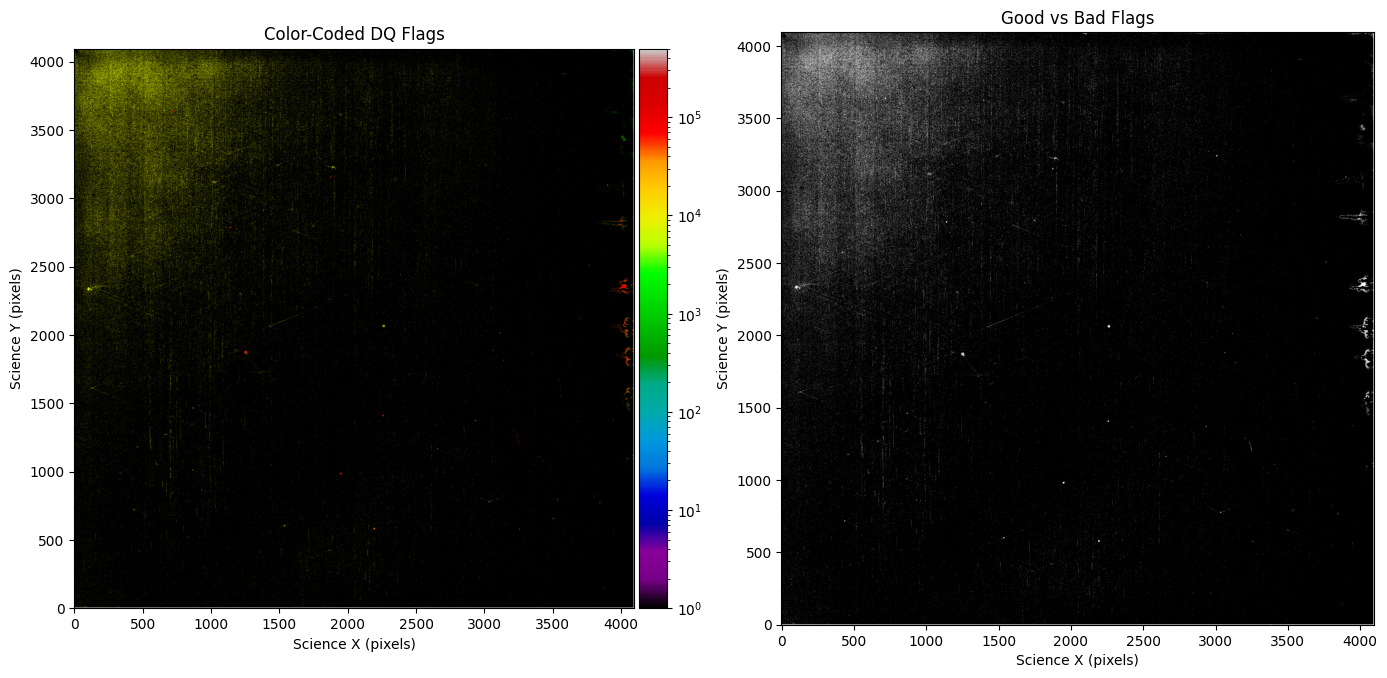

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(14, 14))

# Make a copy of the colormap so we can reset non-finite numbers to black
my_cmap = copy.copy(cm.get_cmap('nipy_spectral'))
my_cmap.set_bad((0, 0, 0))

# Display the mask file with a log normalization using the updated color map
im = axs[0].imshow(mask.dq, origin='lower', norm=colors.LogNorm(vmin=1, vmax=5e5), cmap=my_cmap)
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
axs[0].set_xlabel('Science X (pixels)')
axs[0].set_ylabel('Science Y (pixels)')
axs[0].set_title('Color-Coded DQ Flags')
fig.colorbar(im, cax=cax)

# Display the mask file with boolean good and bad values on a grayscale map
axs[1].imshow(np.bool(mask.dq), origin='lower', cmap='binary_r')
axs[1].set_xlabel('Science X (pixels)')
axs[1].set_ylabel('Science Y (pixels)')
axs[1].set_title('Good vs Bad Flags')

plt.tight_layout();

Note that not all DQ flags > 0 are necessarily bad. Many DQ flags are informational about detector effects or note something about the data processing. It is important for you to decide what effects are important for your science case.

Next, we'll take a look at a dark. This isn't as visually interesting for the WFI as the dark current is so low, so we will simply display the file information and discuss the contents.

**Note:** Dark reference files from the Science Operations Center at STScI are still being developed. The dark files currently in CRDS are placeholders with all-zero values to enable simulations and pipeline processing. Updated darks are expected in early 2026.

In [31]:
dark = rdm.open(ref_files['dark'])
dark.info()

root (AsdfObject)
├─asdf_library (Software)
│ ├─author (str): The ASDF Developers
│ ├─homepage (str): http://github.com/asdf-format/asdf
│ ├─name (str): asdf
│ └─version (str): 4.1.0
├─history (AsdfDictNode)
│ └─extensions (AsdfListNode)
│   ├─0 (ExtensionMetadata) ...
│   ├─1 (ExtensionMetadata) ...
│   └─2 (ExtensionMetadata) ...
└─roman (DarkRef) # Dark Reference File Schema
  ├─meta (AsdfDictNode)
  │ ├─author (str): Rick Cosentino # Author
  │ ├─description (str): Dark reference file matching PRD MA Tables with all zeros with compressed data and  (truncated)
  │ ├─exposure (AsdfDictNode) ...
  │ ├─instrument (AsdfDictNode) ...
  │ ├─origin (Origin): STSCI # Institution / Organization Name
  │ └─4 not shown
  ├─data (NDArrayType) # Dark Current Array ...
  ├─dq (NDArrayType) # 2-D Data Quality Array ...
  ├─dark_slope (NDArrayType) # Dark Current Rate Array ...
  └─dark_slope_error (NDArrayType) # Dark Current Rate Uncertainty Array ...
Some nodes not shown.


In addition to metadata, we see there are several arrays. The `data` array contains a cube of dark values up-the-ramp. This is used in the current version of the ELP, however changes are being made towards a dark rate subtraction post-ramp-fitting. The `dark_slope` array contains the dark rate per pixel, and the `dark_slope_error` is the uncertainty in the dark rate. Finally, a `dq` array is present to flag effects in the dark current (such as hot pixels).

Finally, let's examine a flat reference file:

In [32]:
flat = rdm.open(ref_files['flat'])
flat.info()

root (AsdfObject)
├─asdf_library (Software)
│ ├─author (str): The ASDF Developers
│ ├─homepage (str): http://github.com/asdf-format/asdf
│ ├─name (str): asdf
│ └─version (str): 3.5.0
├─history (AsdfDictNode)
│ └─extensions (AsdfListNode)
│   ├─0 (ExtensionMetadata) ...
│   └─1 (ExtensionMetadata) ...
└─roman (FlatRef) # Flat Reference File Schema
  ├─meta (AsdfDictNode)
  │ ├─author (str): Richard G Cosentino # Author
  │ ├─description (str): Flat reference file using TVAC2 data using CFA data from sRCS LED band 5, combining (truncated)
  │ ├─instrument (AsdfDictNode) ...
  │ ├─origin (Origin): STSCI # Institution / Organization Name
  │ ├─pedigree (str): GROUND # Pedigree
  │ ├─reftype (str): FLAT
  │ ├─telescope (Telescope): ROMAN # Telescope Name
  │ └─useafter (Time): 2023-08-01T00:00:00.000 # Use After Date
  ├─data (NDArrayType) # Flat Data Array ...
  ├─dq (NDArrayType) # 2-D Data Quality Array ...
  └─err (NDArrayType) # Flat Data Uncertainty Array ...
Some nodes not shown.


Once again, we see a `data` array, which in this case is the flatfield values, a `dq` array for flagging effects in the flatfield, and an `error` array. Let's take a look at the flatfield for this detector:

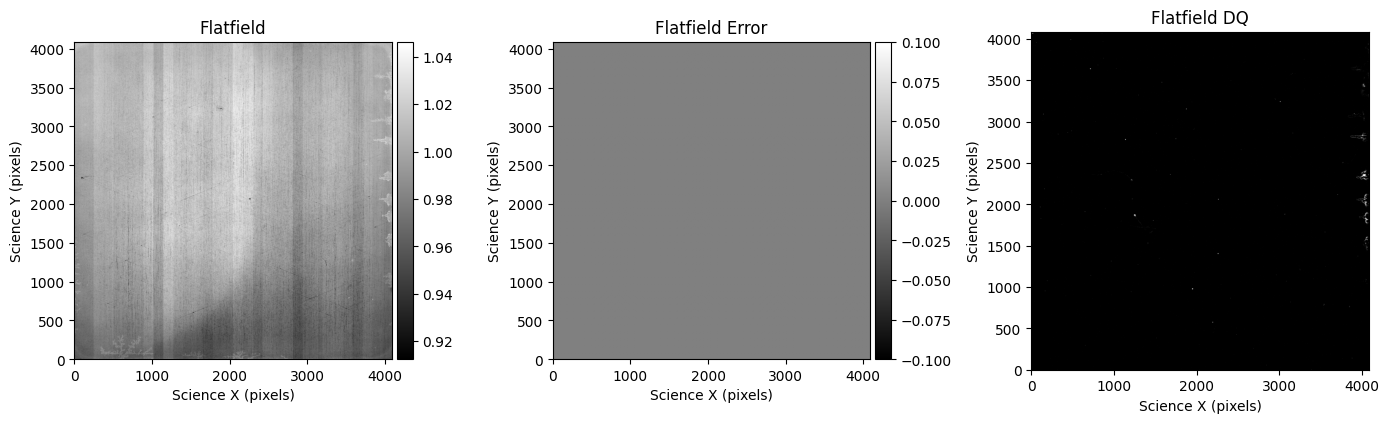

In [33]:
fig, axs = plt.subplots(1, 3, figsize=(14, 14))

norm = simple_norm(flat.data, percent=99.5)
data = axs[0].imshow(flat.data, cmap='gray', norm=norm, origin='lower')
axs[0].set_xlabel('Science X (pixels)')
axs[0].set_ylabel('Science Y (pixels)')
axs[0].set_title('Flatfield')
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(data, cax=cax)

norm = simple_norm(flat.err, percent=99.5)
err = axs[1].imshow(flat.err, cmap='gray', norm=norm, origin='lower')
axs[1].set_xlabel('Science X (pixels)')
axs[1].set_ylabel('Science Y (pixels)')
axs[1].set_title('Flatfield Error')
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(err, cax=cax)

axs[2].imshow(np.bool(flat.dq), cmap='binary_r', origin='lower')
axs[2].set_xlabel('Science X (pixels)')
axs[2].set_ylabel('Science Y (pixels)')
axs[2].set_title('Flatfield DQ')

plt.tight_layout();

## How to Override RomanCal with Local Reference Files

If you have a local reference file that you would like to use in RomanCal processing, either one you retrieved from CRDS or one that you made yourself, then you can supply that when you run the ELP as an optional argument. The new reference file you indicate will override the CRDS best reference file selection from the server. Each reference file type has its own override parameter name (e.g., `override_mask`) and must be passed as arguments to the relevant step. Let's look at an example now where we run the pipeline and override the mask and flat files. First, we need new reference files to use. For this example, let's run `crds.getreferences()` and get new files for a different set of observation parameters, and then we can use those to override the best references. Our example is generally a bad idea, but for real applications you will likely already have a file on your disk storage that you want to use. Our example is to show how to override the reference file selection.

For our example, we will process a WFI01 L1 file with the ELP, but we will override the mask and flat files to be those from WFI04. Again, **this is not recommended** but simply designed to show how to override the reference file selection used by the pipeline if you have your own calibration reference files you want to use.

**Note:** In `romancal` version 0.20.2 (August 2025), there is a bug when overriding reference files. Please make sure to disable the source catalog and tweakreg steps (as shown below) when overriding reference files to bypass this bug. This bug is already fixed in the next `romancal` version (0.21.0; November 2025), which is undergoing testing and validation.

In [34]:
meta = {'ROMAN.META.INSTRUMENT.NAME': 'WFI',
        'ROMAN.META.INSTRUMENT.DETECTOR': 'WFI04',
        'ROMAN.META.INSTRUMENT.OPTICAL_ELEMENT': 'F158',
        'ROMAN.META.EXPOSURE.START_TIME': '2024-01-01 00:00:00'
       }

ref_files = crds.getreferences(meta, reftypes=['mask', 'flat'], observatory='roman')

result = ExposurePipeline.call(dm_l1, save_results=False, steps={
                'source_catalog': {'skip': True},
                'tweakreg': {'skip': True},
                'dq_init': {'override_mask': ref_files['mask']},
                'flatfield': {'override_flat': ref_files['flat']}})

2025-12-11 00:42:40,881 - CRDS - ERROR -  Error determining best reference for 'pars-dqinitstep'  =   No match found.


2025-12-11 00:42:40,882 - CRDS - ERROR -  Error determining best reference for 'pars-saturationstep'  =   No match found.


2025-12-11 00:42:40,883 - CRDS - ERROR -  Error determining best reference for 'pars-refpixstep'  =   No match found.


2025-12-11 00:42:40,884 - CRDS - ERROR -  Error determining best reference for 'pars-linearitystep'  =   No match found.


2025-12-11 00:42:40,885 - CRDS - ERROR -  Error determining best reference for 'pars-darkcurrentstep'  =   No match found.


2025-12-11 00:42:40,886 - CRDS - ERROR -  Error determining best reference for 'pars-rampfitstep'  =   No match found.


2025-12-11 00:42:40,887 - CRDS - ERROR -  Error determining best reference for 'pars-assignwcsstep'  =   No match found.


2025-12-11 00:42:40,888 - CRDS - ERROR -  Error determining best reference for 'pars-flatfieldstep'  =   No match found.


2025-12-11 00:42:40,889 - CRDS - ERROR -  Error determining best reference for 'pars-photomstep'  =   No match found.


2025-12-11 00:42:40,890 - CRDS - ERROR -  Error determining best reference for 'pars-sourcecatalogstep'  =   Unknown reference type 'pars-sourcecatalogstep'


2025-12-11 00:42:40,892 - CRDS - ERROR -  Error determining best reference for 'pars-tweakregstep'  =   No match found.


2025-12-11 00:42:40,893 - CRDS - ERROR -  Error determining best reference for 'pars-exposurepipeline'  =   No match found.


2025-12-11 00:42:40,899 - stpipe.ExposurePipeline - INFO - ExposurePipeline instance created.


2025-12-11 00:42:40,900 - stpipe.ExposurePipeline.dq_init - INFO - DQInitStep instance created.


2025-12-11 00:42:40,901 - stpipe.ExposurePipeline.saturation - INFO - SaturationStep instance created.


2025-12-11 00:42:40,902 - stpipe.ExposurePipeline.refpix - INFO - RefPixStep instance created.


2025-12-11 00:42:40,903 - stpipe.ExposurePipeline.linearity - INFO - LinearityStep instance created.


2025-12-11 00:42:40,904 - stpipe.ExposurePipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-12-11 00:42:40,906 - stpipe.ExposurePipeline.rampfit - INFO - RampFitStep instance created.


2025-12-11 00:42:40,907 - stpipe.ExposurePipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-12-11 00:42:40,907 - stpipe.ExposurePipeline.flatfield - INFO - FlatFieldStep instance created.


2025-12-11 00:42:40,908 - stpipe.ExposurePipeline.photom - INFO - PhotomStep instance created.


2025-12-11 00:42:40,909 - stpipe.ExposurePipeline.source_catalog - INFO - SourceCatalogStep instance created.


2025-12-11 00:42:40,911 - stpipe.ExposurePipeline.tweakreg - INFO - TweakRegStep instance created.


2025-12-11 00:42:41,132 - stpipe.ExposurePipeline - INFO - Step ExposurePipeline running with args (<roman_datamodels.datamodels._datamodels.ScienceRawModel object at 0x7f3cac1667b0>,).


2025-12-11 00:42:41,145 - stpipe.ExposurePipeline - INFO - Step ExposurePipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: None
  output_ext: .asdf
  output_use_model: False
  output_use_index: True
  save_results: False
  skip: False
  suffix: cal
  search_output_file: True
  input_dir: ''
  save_l1_wcs: False
  steps:
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .asdf
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    saturation:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .asdf
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    refpix:
      pre_hooks: []
      

2025-12-11 00:42:41,147 - stpipe.ExposurePipeline - INFO - Prefetching reference files for dataset: 'r0003201001001001004_0001_wfi01_f106_uncal.asdf' reftypes = ['dark', 'distortion', 'gain', 'linearity', 'photom', 'readnoise', 'refpix', 'saturation']


2025-12-11 00:42:41,149 - stpipe.ExposurePipeline - INFO - Prefetch for DARK reference file is '/tmp/crds_cache/references/roman/wfi/roman_wfi_dark_0364.asdf'.


2025-12-11 00:42:41,150 - stpipe.ExposurePipeline - INFO - Prefetch for DISTORTION reference file is '/tmp/crds_cache/references/roman/wfi/roman_wfi_distortion_0014.asdf'.


2025-12-11 00:42:41,150 - stpipe.ExposurePipeline - INFO - Override for FLAT reference file is '/tmp/crds_cache/references/roman/wfi/roman_wfi_flat_0142.asdf'.


2025-12-11 00:42:41,151 - stpipe.ExposurePipeline - INFO - Prefetch for GAIN reference file is '/tmp/crds_cache/references/roman/wfi/roman_wfi_gain_0022.asdf'.


2025-12-11 00:42:41,151 - stpipe.ExposurePipeline - INFO - Prefetch for LINEARITY reference file is '/tmp/crds_cache/references/roman/wfi/roman_wfi_linearity_0039.asdf'.


2025-12-11 00:42:41,152 - stpipe.ExposurePipeline - INFO - Override for MASK reference file is '/tmp/crds_cache/references/roman/wfi/roman_wfi_mask_0022.asdf'.


2025-12-11 00:42:41,152 - stpipe.ExposurePipeline - INFO - Prefetch for PHOTOM reference file is '/tmp/crds_cache/references/roman/wfi/roman_wfi_photom_0040.asdf'.


2025-12-11 00:42:41,153 - stpipe.ExposurePipeline - INFO - Prefetch for READNOISE reference file is '/tmp/crds_cache/references/roman/wfi/roman_wfi_readnoise_0024.asdf'.


2025-12-11 00:42:41,153 - stpipe.ExposurePipeline - INFO - Prefetch for REFPIX reference file is '/tmp/crds_cache/references/roman/wfi/roman_wfi_refpix_0013.asdf'.


2025-12-11 00:42:41,154 - stpipe.ExposurePipeline - INFO - Prefetch for SATURATION reference file is '/tmp/crds_cache/references/roman/wfi/roman_wfi_saturation_0031.asdf'.


2025-12-11 00:42:41,154 - romancal.pipeline.exposure_pipeline - INFO - Starting Roman exposure calibration pipeline ...


2025-12-11 00:42:41,372 - stpipe.ExposurePipeline.dq_init - INFO - Step dq_init running with args (<roman_datamodels.datamodels._datamodels.ScienceRawModel object at 0x7f3cac1667b0>,).


2025-12-11 00:42:41,453 - romancal.dq_init.dq_init_step - INFO - Flagging rows from: -999999 to -999999 as affected by guide window read


2025-12-11 00:42:41,519 - stpipe.ExposurePipeline.dq_init - INFO - Step dq_init done


2025-12-11 00:42:41,746 - stpipe.ExposurePipeline.saturation - INFO - Step saturation running with args (<roman_datamodels.datamodels._datamodels.RampModel object at 0x7f3c9ca46b10>,).


2025-12-11 00:42:41,749 - romancal.saturation.saturation_step - INFO - Using SATURATION reference file: /tmp/crds_cache/references/roman/wfi/roman_wfi_saturation_0031.asdf


2025-12-11 00:42:42,859 - stcal.saturation.saturation - INFO - Detected 73498 saturated pixels


2025-12-11 00:42:42,906 - stcal.saturation.saturation - INFO - Detected 66525 A/D floor pixels


2025-12-11 00:42:42,928 - stpipe.ExposurePipeline.saturation - INFO - Step saturation done


2025-12-11 00:42:43,241 - stpipe.ExposurePipeline.refpix - INFO - Step refpix running with args (<roman_datamodels.datamodels._datamodels.RampModel object at 0x7f3c9ca46b10>,).


/home/runner/micromamba/envs/ci-env/lib/python3.13/site-packages/romancal/refpix/data.py:398: RuntimeWarning: invalid value encountered in divide
  kern = (cov / mask_conv).reshape(rows, columns)


2025-12-11 00:42:45,979 - stpipe.ExposurePipeline.refpix - INFO - Step refpix done


2025-12-11 00:42:46,203 - stpipe.ExposurePipeline.linearity - INFO - Step linearity running with args (<roman_datamodels.datamodels._datamodels.RampModel object at 0x7f3c9ca46b10>,).


2025-12-11 00:42:46,206 - romancal.linearity.linearity_step - INFO - Using LINEARITY reference file: /tmp/crds_cache/references/roman/wfi/roman_wfi_linearity_0039.asdf


2025-12-11 00:42:47,670 - stpipe.ExposurePipeline.linearity - INFO - Step linearity done


2025-12-11 00:42:47,889 - stpipe.ExposurePipeline.rampfit - INFO - Step rampfit running with args (<roman_datamodels.datamodels._datamodels.RampModel object at 0x7f3c9ca46b10>,).


2025-12-11 00:42:47,893 - romancal.ramp_fitting.ramp_fit_step - INFO - Using READNOISE reference file: /tmp/crds_cache/references/roman/wfi/roman_wfi_readnoise_0024.asdf


2025-12-11 00:42:47,908 - romancal.ramp_fitting.ramp_fit_step - INFO - Using GAIN reference file: /tmp/crds_cache/references/roman/wfi/roman_wfi_gain_0022.asdf


2025-12-11 00:42:47,922 - romancal.ramp_fitting.ramp_fit_step - INFO - Jump detection as part of ramp fitting is enabled.


2025-12-11 00:42:55,015 - stpipe.ExposurePipeline.rampfit - INFO - Step rampfit done


2025-12-11 00:42:55,253 - stpipe.ExposurePipeline.dark_current - INFO - Step dark_current running with args (<roman_datamodels.datamodels._datamodels.ImageModel object at 0x7f3c9ca44510>,).


2025-12-11 00:42:55,256 - romancal.dark_current.dark_current_step - INFO - Using DARK reference file: /tmp/crds_cache/references/roman/wfi/roman_wfi_dark_0364.asdf


2025-12-11 00:42:55,977 - stpipe.ExposurePipeline.dark_current - INFO - Step dark_current done


2025-12-11 00:42:56,197 - stpipe.ExposurePipeline.assign_wcs - INFO - Step assign_wcs running with args (<roman_datamodels.datamodels._datamodels.ImageModel object at 0x7f3c9ca44510>,).


2025-12-11 00:42:56,198 - romancal.assign_wcs.assign_wcs_step - INFO - reftype, distortion


2025-12-11 00:42:56,201 - romancal.assign_wcs.assign_wcs_step - INFO - Using reference files: {'distortion': '/tmp/crds_cache/references/roman/wfi/roman_wfi_distortion_0014.asdf'} for assign_wcs


2025-12-11 00:42:56,253 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  270.934685029 -0.225734417 270.934627258 -0.102770948 270.809037196 -0.102466475 270.809759493 -0.225325334


2025-12-11 00:42:56,253 - romancal.assign_wcs.utils - INFO - S_REGION VALUES: POLYGON ICRS  270.934685029 -0.225734417 270.934627258 -0.102770948 270.809037196 -0.102466475 270.809759493 -0.225325334


2025-12-11 00:42:56,254 - romancal.assign_wcs.utils - INFO - Update S_REGION to POLYGON ICRS  270.934685029 -0.225734417 270.934627258 -0.102770948 270.809037196 -0.102466475 270.809759493 -0.225325334


2025-12-11 00:42:56,256 - stpipe.ExposurePipeline.assign_wcs - INFO - Step assign_wcs done


2025-12-11 00:42:56,480 - stpipe.ExposurePipeline.flatfield - INFO - Step flatfield running with args (<roman_datamodels.datamodels._datamodels.ImageModel object at 0x7f3c9ca44510>,).


2025-12-11 00:42:56,761 - stpipe.ExposurePipeline.flatfield - INFO - Step flatfield done


2025-12-11 00:42:56,989 - stpipe.ExposurePipeline.photom - INFO - Step photom running with args (<roman_datamodels.datamodels._datamodels.ImageModel object at 0x7f3c9ca44510>,).


2025-12-11 00:42:57,006 - romancal.photom.photom - INFO - photmjsr value: 0.741749


2025-12-11 00:42:57,006 - romancal.photom.photom - INFO - uncertainty value: 0.0288573


2025-12-11 00:42:57,008 - stpipe.ExposurePipeline.photom - INFO - Step photom done


2025-12-11 00:42:57,231 - stpipe.ExposurePipeline.source_catalog - INFO - Step source_catalog running with args (<roman_datamodels.datamodels._datamodels.ImageModel object at 0x7f3c9ca44510>,).


2025-12-11 00:42:57,231 - stpipe.ExposurePipeline.source_catalog - INFO - Step skipped.


2025-12-11 00:42:57,455 - stpipe.ExposurePipeline.tweakreg - INFO - Step tweakreg running with args (<romancal.datamodels.library.ModelLibrary object at 0x7f3c6c4bb9d0>,).


2025-12-11 00:42:57,456 - stpipe.ExposurePipeline.tweakreg - INFO - Step skipped.


2025-12-11 00:42:57,457 - romancal.pipeline.exposure_pipeline - INFO - Roman exposure calibration pipeline ending...


2025-12-11 00:42:57,458 - stpipe.ExposurePipeline - INFO - Step ExposurePipeline done


Now let's take a look at our `result` variable, which is our L2 datamodel in memory. Specifically, we can check the `meta.ref_file` section to see the names of the reference files used:

In [35]:
for k, v in result.meta.ref_file.items():
    print(f'{k} = {v}')

apcorr = N/A
area = N/A
dark = crds://roman_wfi_dark_0364.asdf
distortion = crds://roman_wfi_distortion_0014.asdf
epsf = N/A
flat = /tmp/crds_cache/references/roman/wfi/roman_wfi_flat_0142.asdf
gain = crds://roman_wfi_gain_0022.asdf
inverse_linearity = N/A
linearity = crds://roman_wfi_linearity_0039.asdf
mask = /tmp/crds_cache/references/roman/wfi/roman_wfi_mask_0022.asdf
photom = crds://roman_wfi_photom_0040.asdf
readnoise = crds://roman_wfi_readnoise_0024.asdf
refpix = crds://roman_wfi_refpix_0013.asdf
saturation = crds://roman_wfi_saturation_0031.asdf
crds = {'version': '13.0.6', 'context': 'roman_0041.pmap'}


Indeed, we see that many of the files used came from CRDS (note the file names begin with "crds://") whereas the flat and mask files contain a local path to the files we selected.

## About this Notebook
**Author:** T. Desjardins.

**Updated On:** 2025-12-10

<table width="100%" style="border:none; border-collapse:collapse;">
  <tr style="border:none;">
    <td style="border:none; width:180px; white-space:nowrap;">
       <a href="#top" style="text-decoration:none; color:#0066cc;">↑ Top of page</a> 
    </td>
    <td style="border:none; text-align:center;">
       <img src="../../roman_logo.png" width="50">
    </td>
    <td style="border:none; text-align:right;">
       <img src="../../stsci_logo2.png" width="90">
    </td>
  </tr>
</table>